In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import tiktoken

In [2]:
! pip install tiktoken

Defaulting to user installation because normal site-packages is not writeable


Building Dataset

In [3]:
# ! wget https://raw.githubusercontent.com/jcjohnson/torch-rnn/master/data/tiny-shakespeare.txt

--2024-09-04 11:11:51--  https://raw.githubusercontent.com/jcjohnson/torch-rnn/master/data/tiny-shakespeare.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8003::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘tiny-shakespeare.txt.2’

tiny-shakespeare.tx 100%[===================>]   1.06M   795KB/s    in 1.4s    

2024-09-04 11:11:53 (795 KB/s) - ‘tiny-shakespeare.txt.2’ saved [1115394/1115394]



In [4]:
with open('./../tiny-shakespeare.txt', 'r') as f:
    text = f.read()

print('Length of dataset', len(text), '\n')
print(text[:100])

Length of dataset 1115394 

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [5]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(f'\nVocabulary size: {vocab_size}')


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz

Vocabulary size: 65


In [6]:
# encode and decoder
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

msg = 'hii there'
token_list = encode(msg)
print(token_list)
print(decode(token_list))


[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


Digression - TikToken

In [7]:
enc = tiktoken.get_encoding('gpt2')

msg = 'hii there'
token_list = enc.encode(msg)
print(token_list)
print(enc.decode(enc.encode('hii there')))

print(enc.n_vocab)

[71, 4178, 612]
hii there
50257


Tokenizing the dataset

In [8]:
data = torch.tensor(encode(text), dtype=torch.long)
print(f'Total size: {data.shape} elements of type {data.dtype}')
print('First 10 token form dataset', data[:10])

Total size: torch.Size([1115394]) elements of type torch.int64
First 10 token form dataset tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47])


Splitting the dataset

In [9]:
n = int(0.9 * len(data)) # split here 90%
print(n)
train_data = data[:n]
val_data = data[n:]

1003854


In [10]:
block_size = 8
train_data[:block_size + 1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [11]:
# first block 
x = train_data[:block_size]
# individual token shifted by one
y = train_data[1:block_size+1]

for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f'when the prompt is {context}, predict is {target}')

when the prompt is tensor([18]), predict is 47
when the prompt is tensor([18, 47]), predict is 56
when the prompt is tensor([18, 47, 56]), predict is 57
when the prompt is tensor([18, 47, 56, 57]), predict is 58
when the prompt is tensor([18, 47, 56, 57, 58]), predict is 1
when the prompt is tensor([18, 47, 56, 57, 58,  1]), predict is 15
when the prompt is tensor([18, 47, 56, 57, 58,  1, 15]), predict is 47
when the prompt is tensor([18, 47, 56, 57, 58,  1, 15, 47]), predict is 58


In [12]:
torch.manual_seed(1337)
batch_size = 4 # number of sequence to be processed in parallel (for gpu)
block_size = 8 # length of sequence 

In [13]:
def get_batch(split, batch_size):
    data = train_data if split == 'train' else val_data
    # Tensor of shape (batch_size,) with random sequence start indices between 0 and len(data) - block_size
    ix = torch.randint(len(data) - block_size, (batch_size,))

    # Accumulate and add each sequence of this batch to form a tensor
    x = torch.stack([data[i:i+block_size] for i in ix])
    # Same as x but shifted by one token
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x , y

xb , yb = get_batch('train', batch_size)

print('inputs shape: ', xb.shape)
print(xb,'\n')
print('targets shape: ', yb.shape)
print(yb, '\n')

# print first batch 
for b in range(batch_size):
    for t in range(block_size):
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f'When the prompt is {context}, predict {target}')

inputs shape:  torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]]) 

targets shape:  torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]]) 

When the prompt is tensor([24]), predict 43
When the prompt is tensor([24, 43]), predict 58
When the prompt is tensor([24, 43, 58]), predict 5
When the prompt is tensor([24, 43, 58,  5]), predict 57
When the prompt is tensor([24, 43, 58,  5, 57]), predict 1
When the prompt is tensor([24, 43, 58,  5, 57,  1]), predict 46
When the prompt is tensor([24, 43, 58,  5, 57,  1, 46]), predict 43
When the prompt is tensor([24, 43, 58,  5, 57,  1, 46, 43]), predict 39
When the prompt is tensor([44]), predict 53
When the prompt is tensor([44, 53]), predict 56
When the prompt is tensor([44, 53, 

Embedding Layer

In [14]:
torch.manual_seed(1337)

class BigramLM(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # embedding the vocabulary
        # Every one of the vocab_size tokens is represented by a vector of size vocab_size
        self.embed = nn.Embedding(vocab_size, vocab_size) # 65 unique 65-dim vectors
    
    def forward(self, idx, targets):
        # idx - shape (batch_size, block_size)
        # targets - shape (batch_size, block_size)
        # Embed the input indices, shape is now (batch_size, block_size, vocab_size) (B, T, C)
        logits = self.embed(idx)
        return logits
    
print('Vocabulary size:', vocab_size)  # Length of the vocabulary list (this includes the space character)
m = BigramLM(vocab_size)  # Instantiate the model
out = m.forward(xb, yb)           # Forward pass (yb remains unused for now)
print(out.shape)    # (batch_size, block_size, vocab_size) -> 4 times 8 characters, each embedded as a 65-dim vector



Vocabulary size: 65
torch.Size([4, 8, 65])


Setting up Loss Functions

In [15]:
torch.manual_seed(1337)

class BigramLM(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # embedding the vocabulary
        # Every one of the vocab_size tokens is represented by a vector of size vocab_size
        self.embed = nn.Embedding(vocab_size, vocab_size) # 65 unique 65-dim vectors
    
    def forward(self, idx, targets):
        logits = self.embed(idx)      # Embed the input indices, shape is now (batch_size, block_size, vocab_size) (B, T, C)
        B, T, C = logits.shape        # B = batch_size, T = block_size, C = vocab_size
        logits = logits.view(B*T, C)  # Transpose logits to (B*T, C)
        # This is the first time we actively use the targets:
        targets = targets.view(B*T)   # Transpose targets to (B*T) (targets contains the next token's index for each input sequence in the batch)
        loss = F.cross_entropy(logits, targets)  # Calculating cross entropy loss across all tokens in the batch (using targets to plug out the correct token for each input sequence)
        return logits, loss

    
print('Vocabulary size:', vocab_size)  # Length of the vocabulary list (this includes the space character)
m = BigramLM(vocab_size)  # Instantiate the model
logits, loss = m(xb, yb)
print(logits.shape)
print(loss.item())



Vocabulary size: 65
torch.Size([32, 65])
4.878634929656982


> adding genrate() to BigramLM

In [16]:
torch.manual_seed(1337)

class BigramLM(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # embedding the vocabulary
        # Every one of the vocab_size tokens is represented by a vector of size vocab_size
        self.embed = nn.Embedding(vocab_size, vocab_size) # 65 unique 65-dim vectors
    
    def forward(self, idx, targets=None):
        logits = self.embed(idx)                               # Embed the input indices, shape is now (batch_size, block_size, vocab_size) (B, T, C)
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)                       # Transpose logits to (B, C, T) (B=batch_size, T=block_size, C=vocab_size)
            targets = targets.view(B*T)                        # Transpose targets to (B, T)
            loss = F.cross_entropy(logits, targets)            # Calculating cross entropy loss across all tokens in the batch
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, _ = self(idx)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx
   
print('Vocabulary size:', vocab_size)  # Length of the vocabulary list (this includes the space character)
m = BigramLM(vocab_size)  # Instantiate 
logits, loss = m(xb, yb)

print(logits.shape, '\n', loss)



Vocabulary size: 65
torch.Size([32, 65]) 
 tensor(4.8786, grad_fn=<NllLossBackward0>)


Producing First Text

In [17]:
ix = torch.zeros((1, 1), dtype=torch.long)  # Start with a single tensor of shape (1, 1) holding a 0 (new line)
tokens = m.generate(ix, max_new_tokens=100) # Generate 100 tokens as a sequence of indices
print(tokens.shape)                         # Print the shape of the resulting sequence of tokens
print(decode(tokens[0].tolist()))           # Decode the resulting sequence of indices to a string

torch.Size([1, 101])

Sr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3


train

In [18]:
opt = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [19]:
batch_size = 32
losses = []

for steps in range(10000):
    xb, yb = get_batch('train', batch_size)     # sample batch of data
    logits, loss = m(xb, yb)                    # forward pass
    loss.backward()                             # Backdrop with pytorch autograd (updt. logits - the embedding vector)

    opt.step()                                   # update weights
    opt.zero_grad()                              # Set gradients to zero

    if steps % 100 == 0:
        print(f'Loss at steps {steps}: {loss.item()}')
        losses.append(loss.item())

Loss at steps 0: 4.704006195068359
Loss at steps 100: 4.658433437347412
Loss at steps 200: 4.470171928405762
Loss at steps 300: 4.320702075958252
Loss at steps 400: 4.252743721008301
Loss at steps 500: 4.241008758544922
Loss at steps 600: 4.161406517028809
Loss at steps 700: 4.044336795806885
Loss at steps 800: 4.091874122619629
Loss at steps 900: 3.7458465099334717
Loss at steps 1000: 3.7031264305114746
Loss at steps 1100: 3.7115283012390137
Loss at steps 1200: 3.6330997943878174
Loss at steps 1300: 3.422212600708008
Loss at steps 1400: 3.4295449256896973
Loss at steps 1500: 3.4233598709106445
Loss at steps 1600: 3.3018524646759033
Loss at steps 1700: 3.283510446548462
Loss at steps 1800: 3.188281774520874
Loss at steps 1900: 3.2000553607940674
Loss at steps 2000: 3.1371781826019287
Loss at steps 2100: 3.0028276443481445
Loss at steps 2200: 3.058077812194824
Loss at steps 2300: 2.958632707595825
Loss at steps 2400: 2.981365919113159
Loss at steps 2500: 2.9196817874908447
Loss at steps

In [20]:
# sampling from model 
print(decode(m.generate(torch.zeros((1,1,), dtype=torch.long), max_new_tokens=1000)[0].tolist()))


Iyoteng h hasbe pave pirance
Rie hicomyonthar's
Plinseard ith henoure wounonthioneir thondy, y heltieiengerofo'dsssit ey
KIN d pe wither vouprrouthercc.
hathe; d!
My hind tt hinig t ouchos tes; st yo hind wotte grotonear 'so it t jod weancotha:
h hay.JUCle n prids, r loncave w hollular s O:
HIs; ht anjx?

DUThinqunt.

LaZAnde.
athave l.
KEONH:
ARThanco be y,-hedarwnoddy scace, tridesar, wnl'shenous s ls, theresseys
PlorseelapinghiybHen yof GLUCEN t l-t E:
I hisgothers je are!-e!
QLYotouciullle'z,
Thitertho s?
NDan'spererfo cist ripl chys er orlese;
Yo jehof h hecere ek? wferommot mowo soaf yoit, ince his, t, f at. fal whetrimy bupof tor atha Bu!
JOutho f cimimave.
NEDUSt cir selle p wie wede
Ro n apenor f'Y tover witys an sh d w t e w!
CEOntiretoaveE IINpe, theck. cung.
ORIsthies hacin benqurd bll, d a r w wistatsowor ath
Fivet bloll ang a-I theeancu,
LINCI'T:
Sarry t I Ane sze t
LCKI thit,
n.
Faure ds ppplirn!
meftou ow pring, avewist th;
TENTEMETCI gienco, An he waro whiougou he s i

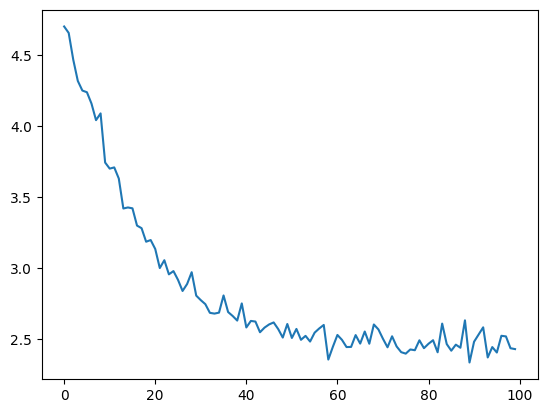

In [21]:
import matplotlib.pyplot as plt 
plt.plot(losses)

The mathematical trick in Self-Attention

In [22]:
torch.manual_seed(1337)
B, T, C = 4, 8, 2
x = torch.randn(B, T, C)


In [23]:
xbow = torch.zeros((B,T,C))         # Create tensor of zeros of shape (B, T, C) 
for b in range(B):                       # For all batches
    for t in range(T):                  #  For all tokens in the batch  
        xprev = x[b, :t+1]             # Get all tokens up to and including the current token 
        xbow[b,t] = xprev.mean(dim=0)  # Calculate the mean of the tokens up to and including the current token

print('Batch [0]:\n', x[0], '\n')
print('Running Average:\n', xbow[0])

Batch [0]:
 tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398],
        [-0.9211,  1.5433]]) 

Running Average:
 tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])


In [24]:
# loops are inefficent so , 
torch.manual_seed(42)
a = torch.ones(3,3)
b = torch.randint(0,10,(3,2)).float()
c = a @ b

print(f'a (ones) =\n{a}\n')
print(f'b (random) =\n{b}\n')
print(f'c = a @ b =\n{c}\n')


a (ones) =
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])

b (random) =
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])

c = a @ b =
tensor([[14., 16.],
        [14., 16.],
        [14., 16.]])



In [25]:
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))            # Lower triangular matrix of ones (tril used here)
b = torch.randint(0, 10, (3, 2)).float()    # 3x2 matrix of random integers between 0 and 9
c = a @ b                                   # Matrix multiplication of a and b

print(f'a (ones + tril) =\n{a}\n')
print(f'b (random) =\n{b}\n')
print(f'c = a @ b =\n{c}\n')


a (ones + tril) =
tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

b (random) =
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])

c = a @ b =
tensor([[ 2.,  7.],
        [ 8., 11.],
        [14., 16.]])



In [26]:
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))   # Lower triangular matrix of ones
a = a / a.sum(dim=1, keepdim=True) # Normalize the matrix by dividing along each row
b = torch.randint(0, 10, (3, 2)).float() # 3x2 matrix of random integers between 0 and 9
c = a @ b                                # Matrix multiplication of a and b

print(f'a (ones + tril + avg) =\n{a}\n')
print(f'b (random) =\n{b}\n')
print(f'c = a @ b =\n{c}\n')

a (ones + tril + avg) =
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])

b (random) =
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])

c = a @ b =
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])



In [27]:
# applying this to our context, we can get the running average of the tokens in the batch 
# by multiplying the batch with torch.tril(a)

B, T, C = 4, 8 , 2
x = torch.randn(B, T, C)

# old 
xbow = torch.zeros((B,T,C))
for b in range(B):
    for t in range(T):
        xprev = x[b, :t+1]
        xbow[b,t] = xprev.mean(dim = 0)
    
# new 
wei = torch.tril(torch.ones(T,T))
wei = wei / wei.sum(dim=1, keepdim=True)
xbow2 = wei @ x     # (T, T) @ (B, T, C) -> PyTorch's Auto-Stride -> (B, T, T) @ (B, T, C) = (B, T, C)


torch.allclose(xbow, xbow2)

True

adding softmax

In [28]:
# New:
wei = torch.tril(torch.ones(T, T))       # Lower triangular matrix of ones
wei = wei / wei.sum(dim=1, keepdim=True) # Normalizing wei by dividing by the sum of each row
xbow2 = wei @ x                          # (T, T) @ (B, T, C) -> (B, T, T) @ (B, T, C) = (B, T, C)

# Newer:
tril = torch.tril(torch.ones(T,T))

wei = torch.zeros((T,T))
# print(wei)
wei = wei.masked_fill(tril == 0, float('-inf'))
# print(wei)
wei = F.softmax(wei, dim=-1)

xbow3 = wei @ x
torch.allclose(xbow2, xbow3)

True

In [29]:
# row wise softmax

exwei = torch.tensor([[0, 0, float('-inf'), float('-inf'), float('-inf'), float('-inf'), float('-inf')],  [0, 0, 0, float('-inf'), float('-inf'), float('-inf'), float('-inf')]])
print(exwei)
exsof = F.softmax(exwei, dim=-1) # -1 means the last dimension
print(exsof)

tensor([[0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf]])
tensor([[0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000]])


In [30]:
tril = torch.tril(torch.ones(T, T))             # Lower triangular matrix of ones
wei = torch.zeros((T, T))                       # (T, T)
wei = wei.masked_fill(tril == 0, float('-inf')) # Masking all values in wei where tril == 0 with -inf
wei = F.softmax(wei, dim=-1)                    # (T, T)
xbow3 = wei @ x                                 # (T, T) @ (B, T, C) -> (B, T, T) @ (B, T, C) = (B, T, C)

print(wei[0:3])

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])


Self - Attention

In [58]:
key = nn.Linear(C, 16, bias=False)
query = nn.Linear(C, 16, bias=False)
k = key(x)
q = query(x)
print(q.shape)
k = k.transpose(-2, -1)
print(k.shape)
wei = q @ k
wei.shape

torch.Size([4, 8, 16])
torch.Size([4, 16, 8])


torch.Size([4, 8, 8])

In [60]:
torch.manual_seed(1337)
B, T, C = 4,8,32    # batch, Time. Channels
x = torch.randn(B,T,C)

# Single Head Self Attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)

# value = nn.Linear(C, head)
k = key(x)      # (B, T, 16)    
q = query(x)    # (B, T, 16)     
wei = q @ k.transpose(-2, -1)   # (B, T, 16) @ (B, 16, T) --> (B, T, T)

tril = torch.tril(torch.ones(T,T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)

v = value(x)

out = wei @ v
out.shape

torch.Size([4, 8, 32])

Scaled Dot product attention  
handles unit variance

In [61]:
k = torch.randn(B, T, head_size)
q = torch.randn(B, T, head_size)
wei = q @ k.transpose(-2, -1) * head_size ** -0.5

In [62]:
print(k.var())
print(q.var())
print(wei.var())

tensor(0.9487)
tensor(1.0449)
tensor(0.8980)
